# Modeling

## Setup

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split


## Data Loading

In [14]:
df = pd.read_csv('data/processed/modeling_dataset.csv')
df.head()

,PMID,text,Terms,has_mechanism
0,15165820,"Comparative genomic analyses of frog virus 3, ...",NaN,False
1,16912294,Genome of invertebrate iridescent virus type 3...,NaN,False
2,11448171,Analysis of the first complete DNA sequence of...,NaN,False
3,17239238,Comparative genomic analysis of the family Iri...,NaN,False
4,20633916,"Frog virus 3 ORF 53R, a putative myristoylated...",NaN,False


## Quick Look at Data

In [6]:

# Quick look at what we have
print(f"Total papers: {len(df):,}")
print(f"Labeled: {df['has_mechanism'].sum():,}")
print(f"\nColumns: {df.columns.tolist()}")
df.head(3)

Total papers: 254,199
Labeled: 1,334

Columns: ['PMID', 'text', 'Terms', 'has_mechanism']


,PMID,text,Terms,has_mechanism
0,15165820,"Comparative genomic analyses of frog virus 3, ...",NaN,False
1,16912294,Genome of invertebrate iridescent virus type 3...,NaN,False
2,11448171,Analysis of the first complete DNA sequence of...,NaN,False


In [7]:
# Fix NaN in Terms column
df['Terms'] = df['Terms'].fillna('')

# Look at labeled data only
labeled_df = df[df['has_mechanism']].copy()

# Count each mechanism type
all_terms = []
for terms_str in labeled_df['Terms']:
    if terms_str:
        all_terms.extend([t.strip() for t in terms_str.split(',')])

term_counts = pd.Series(all_terms).value_counts()
print("Class distribution:")
print(term_counts)
print(f"\nTotal labeled papers: {len(labeled_df)}")
print(f"Papers with multiple labels: {labeled_df['Terms'].str.contains(',', na=False).sum()}")

Class distribution:
autophosphorylation    721
autoregulation         163
autocatalytic          147
autoinhibition         122
autoubiquitination     121
autolysis               41
autoinducer             38
Name: count, dtype: int64

Total labeled papers: 1334
Papers with multiple labels: 18


## Stage 1: Binary Classification

### Step 1: Prepare Stage 1 Dataset

In [15]:
# Create Stage 1 binary labels
# All labeled papers (any mechanism) = positive (1)
# Unlabeled = unknown (0 for now, but we'll handle properly)

df_stage1 = df.copy()
df_stage1['binary_label'] = df_stage1['has_mechanism'].astype(int)

# Check distribution
print("Stage 1 labels:")
print(f"Positive (has mechanism): {(df_stage1['binary_label'] == 1).sum():,}")
print(f"Unlabeled (unknown): {(df_stage1['binary_label'] == 0).sum():,}")

Stage 1 labels:
Positive (has mechanism): 1,334
Unlabeled (unknown): 252,865


### Step 2: Split Stage 1 Data

In [16]:
# Separate positive and unlabeled
positive_df = df_stage1[df_stage1['binary_label'] == 1].copy()
unlabeled_df = df_stage1[df_stage1['binary_label'] == 0].copy()

# Split positives into train/val/test (same 70/15/15 split)
pos_train, pos_temp = train_test_split(positive_df, test_size=0.3, random_state=42)
pos_val, pos_test = train_test_split(pos_temp, test_size=0.5, random_state=42)

print(f"Positive train: {len(pos_train)}")
print(f"Positive val: {len(pos_val)}")
print(f"Positive test: {len(pos_test)}")
print(f"Unlabeled pool: {len(unlabeled_df):,}")

Positive train: 933
Positive val: 200
Positive test: 201
Unlabeled pool: 252,865


### Step 3: Sample Unlabeled for Initial Training

In [17]:
# Sample unlabeled for training (2:1 ratio)
# 933 positives → sample ~1,866 unlabeled
n_unlabeled_sample = len(pos_train) * 2

unlabeled_train = unlabeled_df.sample(n=n_unlabeled_sample, random_state=42)

# For val/test, use smaller samples
unlabeled_val = unlabeled_df.drop(unlabeled_train.index).sample(n=len(pos_val) * 2, random_state=42)
unlabeled_test = unlabeled_df.drop(unlabeled_train.index.union(unlabeled_val.index)).sample(n=len(pos_test) * 2, random_state=42)

print("Stage 1 binary classification splits:")
print(f"Train: {len(pos_train)} positive + {len(unlabeled_train)} unlabeled = {len(pos_train) + len(unlabeled_train)} total")
print(f"Val: {len(pos_val)} positive + {len(unlabeled_val)} unlabeled = {len(pos_val) + len(unlabeled_val)} total")
print(f"Test: {len(pos_test)} positive + {len(unlabeled_test)} unlabeled = {len(pos_test) + len(unlabeled_test)} total")

Stage 1 binary classification splits:
Train: 933 positive + 1866 unlabeled = 2799 total
Val: 200 positive + 400 unlabeled = 600 total
Test: 201 positive + 402 unlabeled = 603 total


### Step 4: Combine and Save Stage 1 Splits

In [18]:
# Combine positive + unlabeled for each split
stage1_train = pd.concat([pos_train, unlabeled_train]).sample(frac=1, random_state=42)  # shuffle
stage1_val = pd.concat([pos_val, unlabeled_val]).sample(frac=1, random_state=42)
stage1_test = pd.concat([pos_test, unlabeled_test]).sample(frac=1, random_state=42)

# Save
stage1_train.to_csv('data/processed/stage1_train.csv', index=False)
stage1_val.to_csv('data/processed/stage1_val.csv', index=False)
stage1_test.to_csv('data/processed/stage1_test.csv', index=False)

print("\n✓ Saved Stage 1 splits")


✓ Saved Stage 1 splits


### Step 5 Load PubMedBERT Model

In [21]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load PubMedBERT tokenizer and model (force safetensors to avoid torch.load security issue)
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification",
    use_safetensors=True  # Added this
)

model = model.to(device)

print(f"\n✓ Loaded {model_name}")
print(f"Model parameters: {model.num_parameters():,}")

Using device: cpu


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ Loaded microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext
Model parameters: 109,483,778


### Step 6: Prepare Dataset for Training

In [22]:
# Load the splits
stage1_train = pd.read_csv('data/processed/stage1_train.csv')
stage1_val = pd.read_csv('data/processed/stage1_val.csv')
stage1_test = pd.read_csv('data/processed/stage1_test.csv')

# Check text lengths (in tokens, not characters)
sample_text = stage1_train['text'].iloc[0]
tokens = tokenizer.encode(sample_text)
print(f"Example text length: {len(tokens)} tokens")
print(f"BERT max length: 512 tokens")

# Check if we need truncation
all_lengths = stage1_train['text'].apply(lambda x: len(tokenizer.encode(x, add_special_tokens=True)))
print(f"\nToken lengths - Mean: {all_lengths.mean():.0f}, Max: {all_lengths.max()}, >512: {(all_lengths > 512).sum()}")

Example text length: 191 tokens
BERT max length: 512 tokens

Token lengths - Mean: 273, Max: 715, >512: 25


### Step 7: Create PyTorch Dataset

In [23]:
from torch.utils.data import Dataset, DataLoader

class MechanismDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.texts = dataframe['text'].values
        self.labels = dataframe['binary_label'].values
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset = MechanismDataset(stage1_train, tokenizer)
val_dataset = MechanismDataset(stage1_val, tokenizer)
test_dataset = MechanismDataset(stage1_test, tokenizer)

print(f"Train dataset: {len(train_dataset)} examples")
print(f"Val dataset: {len(val_dataset)} examples")
print(f"Test dataset: {len(test_dataset)} examples")

Train dataset: 2799 examples
Val dataset: 600 examples
Test dataset: 603 examples


### Step 8: Create DataLoaders

In [24]:
# Create dataloaders
batch_size = 16  # Adjust based on your memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")

Batch size: 16
Train batches: 175
Val batches: 38


### Step 9: Set Up Training

In [26]:
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

# Training parameters
epochs = 3
learning_rate = 2e-5

# Optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate)

# Learning rate scheduler
total_steps = len(train_loader) * epochs
warmup_steps = total_steps // 10

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

print(f"Training setup:")
print(f"Epochs: {epochs}")
print(f"Learning rate: {learning_rate}")
print(f"Total steps: {total_steps}")
print(f"Warmup steps: {warmup_steps}")

Training setup:
Epochs: 3
Learning rate: 2e-05
Total steps: 525
Warmup steps: 52


### Step 10: Training Loop

In [27]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tqdm import tqdm

def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []
    
    for batch in tqdm(dataloader, desc="Training"):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        # Get predictions
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def evaluate(model, dataloader, device):
    model.eval()
    total_loss = 0
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            
            total_loss += loss.item()
            
            preds = torch.argmax(outputs.logits, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')
    
    return avg_loss, accuracy, precision, recall, f1

print("✓ Training functions ready")

✓ Training functions ready


In [29]:
import os

# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

# Train the model
best_f1 = 0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)
    val_loss, val_acc, val_prec, val_rec, val_f1 = evaluate(model, val_loader, device)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Val Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, F1: {val_f1:.4f}")
    
    # Save best model
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), 'models/stage1_best.pt')
        print(f"✓ Saved best model (F1: {best_f1:.4f})")


Epoch 1/3


Evaluating: 100%|██████████| 38/38 [01:24<00:00,  2.23s/it]


Train Loss: 0.1552, Train Acc: 0.9446
Val Loss: 0.1621, Val Acc: 0.9400
Val Precision: 0.8905, Recall: 0.9350, F1: 0.9122
✓ Saved best model (F1: 0.9122)

Epoch 2/3


Evaluating: 100%|██████████| 38/38 [01:27<00:00,  2.30s/it]


Train Loss: 0.0903, Train Acc: 0.9700
Val Loss: 0.1811, Val Acc: 0.9383
Val Precision: 0.8756, Recall: 0.9500, F1: 0.9113

Epoch 3/3


Evaluating: 100%|██████████| 38/38 [01:25<00:00,  2.25s/it]

Train Loss: 0.0688, Train Acc: 0.9804
Val Loss: 0.1811, Val Acc: 0.9383
Val Precision: 0.8756, Recall: 0.9500, F1: 0.9113


In [30]:
# Load best model
model.load_state_dict(torch.load('models/stage1_best.pt'))

# Evaluate on test set
test_loss, test_acc, test_prec, test_rec, test_f1 = evaluate(model, test_loader, device)

print("\nTest Set Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Precision: {test_prec:.4f}")
print(f"Recall: {test_rec:.4f}")
print(f"F1 Score: {test_f1:.4f}")

/var/folders/n9/9tsj9gw15ll9ycvpvm3m3pq80000gn/T/ipykernel_62294/1517183823.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('models/stag


Test Set Performance:
Accuracy: 0.9453
Precision: 0.9158
Recall: 0.9204
F1 Score: 0.9181


In [31]:
# Get predictions with confidence scores
def get_predictions_with_confidence(model, dataloader, device):
    model.eval()
    all_probs = []
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Getting predictions"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of class 1 (mechanism)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_probs), np.array(all_preds), np.array(all_labels)

# Get confidence on test set
test_probs, test_preds, test_labels = get_predictions_with_confidence(model, test_loader, device)

# Analyze confidence for true positives (labeled as mechanism)
true_positive_mask = test_labels == 1
tp_confidences = test_probs[true_positive_mask]
print(f"Labeled positives - Mean confidence: {tp_confidences.mean():.4f}, Min: {tp_confidences.min():.4f}")

# Analyze "unlabeled" predictions (could be true negatives OR unlabeled positives)
unlabeled_mask = test_labels == 0
unlabeled_confidences = test_probs[unlabeled_mask]
print(f"Unlabeled - Mean confidence: {unlabeled_confidences.mean():.4f}, Max: {unlabeled_confidences.max():.4f}")

Getting predictions: 100%|██████████| 38/38 [01:27<00:00,  2.31s/it]

Labeled positives - Mean confidence: 0.8918, Min: 0.0086
Unlabeled - Mean confidence: 0.0668, Max: 0.9845


In [32]:
# Find the low-confidence labeled positive (possible mislabel)
low_conf_idx = np.where(true_positive_mask)[0][np.argmin(tp_confidences)]
print("LOW CONFIDENCE LABELED POSITIVE:")
print(f"PMID: {stage1_test.iloc[low_conf_idx]['PMID']}")
print(f"Confidence: {tp_confidences.min():.4f}")
print(f"Terms: {stage1_test.iloc[low_conf_idx]['Terms']}")
print(f"Text: {stage1_test.iloc[low_conf_idx]['text'][:300]}...\n")

# Find high-confidence unlabeled papers (potential unreported mechanisms)
high_conf_unlabeled = np.where((unlabeled_mask) & (test_probs > 0.9))[0]
print(f"HIGH CONFIDENCE UNLABELED PAPERS: {len(high_conf_unlabeled)}")
if len(high_conf_unlabeled) > 0:
    for idx in high_conf_unlabeled[:3]:  # Show top 3
        print(f"\nPMID: {stage1_test.iloc[idx]['PMID']}")
        print(f"Confidence: {test_probs[idx]:.4f}")
        print(f"Text: {stage1_test.iloc[idx]['text'][:300]}...")

LOW CONFIDENCE LABELED POSITIVE:
PMID: 10838186
Confidence: 0.0086
Terms: autocatalytic
Text: Identification of a novel aspartic-like protease differentially expressed in human breast cancer cell lines.. Four different human breast cancer cell lines were examined to search for genes associated with tumor growth and metastasis. Each of these cell lines, MDA-MB-453, MCF-7, MDA-MB-231 and MDA-M...

HIGH CONFIDENCE UNLABELED PAPERS: 8

PMID: 17190791
Confidence: 0.9489
Text: Regulation of activity and localization of the WNK1 protein kinase by hyperosmotic stress.. Mutations within the WNK1 (with-no-K[Lys] kinase-1) gene cause Gordon's hypertension syndrome. Little is known about how WNK1 is regulated. We demonstrate that WNK1 is rapidly activated and phosphorylated at ...

PMID: 19765683
Confidence: 0.9105
Text: Heterozygous NTF4 mutations impairing neurotrophin-4 signaling in patients with primary open-angle glaucoma.. Glaucoma, a main cause of blindness in the developed world, is charac

## Stage 2: Multi-class Classification

### Step 1: Prepare Stage 2 Data

In [33]:
# Load the labeled-only splits we created earlier
train_df = pd.read_csv('data/processed/train.csv')
val_df = pd.read_csv('data/processed/val.csv')
test_df = pd.read_csv('data/processed/test.csv')

# Create numeric labels for the 7 classes
label_map = {
    'autophosphorylation': 0,
    'autoregulation': 1,
    'autocatalytic': 2,
    'autoinhibition': 3,
    'autoubiquitination': 4,
    'autolysis': 5,
    'autoinducer': 6
}

# Apply mapping
train_df['numeric_label'] = train_df['label'].map(label_map)
val_df['numeric_label'] = val_df['label'].map(label_map)
test_df['numeric_label'] = test_df['label'].map(label_map)

print(f"Stage 2 (7-class) splits:")
print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")
print(f"\nClass distribution in training:")
print(train_df['label'].value_counts().sort_index())

Stage 2 (7-class) splits:
Train: 933, Val: 200, Test: 201

Class distribution in training:
label
autocatalytic          103
autoinducer             27
autoinhibition          85
autolysis               27
autophosphorylation    499
autoregulation         110
autoubiquitination      82
Name: count, dtype: int64


### Step 2: Create Stage 2 Dataset

In [34]:
class MultiClassDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=512):
        self.texts = dataframe['text'].values
        self.labels = dataframe['numeric_label'].values
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Create datasets
train_dataset_s2 = MultiClassDataset(train_df, tokenizer)
val_dataset_s2 = MultiClassDataset(val_df, tokenizer)
test_dataset_s2 = MultiClassDataset(test_df, tokenizer)

# Create dataloaders
train_loader_s2 = DataLoader(train_dataset_s2, batch_size=16, shuffle=True)
val_loader_s2 = DataLoader(val_dataset_s2, batch_size=16)
test_loader_s2 = DataLoader(test_dataset_s2, batch_size=16)

print(f"Stage 2 datasets ready")
print(f"Train batches: {len(train_loader_s2)}")

Stage 2 datasets ready
Train batches: 59


### Step 3: Load New Model with Class Weights

In [35]:
from sklearn.utils.class_weight import compute_class_weight

# Load fresh PubMedBERT for 7-way classification
model_s2 = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=7,
    problem_type="single_label_classification",
    use_safetensors=True
)
model_s2 = model_s2.to(device)

# Calculate class weights to handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['numeric_label']),
    y=train_df['numeric_label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print("Class weights (higher = rarer class):")
for label, weight in zip(label_map.keys(), class_weights):
    print(f"{label:20} {weight:.2f}")

print(f"\n✓ Loaded Stage 2 model with {model_s2.num_parameters():,} parameters")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Class weights (higher = rarer class):
autophosphorylation  0.27
autoregulation       1.21
autocatalytic        1.29
autoinhibition       1.57
autoubiquitination   1.63
autolysis            4.94
autoinducer          4.94

✓ Loaded Stage 2 model with 109,487,623 parameters


### Step 4: Setup Stage 2 Training with Weighted Loss

In [36]:
# Training parameters
epochs_s2 = 4  # Slightly more epochs for harder task
learning_rate_s2 = 2e-5

# Optimizer and scheduler
optimizer_s2 = AdamW(model_s2.parameters(), lr=learning_rate_s2)
total_steps_s2 = len(train_loader_s2) * epochs_s2
warmup_steps_s2 = total_steps_s2 // 10

scheduler_s2 = get_linear_schedule_with_warmup(
    optimizer_s2,
    num_warmup_steps=warmup_steps_s2,
    num_training_steps=total_steps_s2
)

# Weighted loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)

print(f"Stage 2 training setup:")
print(f"Epochs: {epochs_s2}")
print(f"Total steps: {total_steps_s2}")
print(f"Using weighted CrossEntropyLoss")

Stage 2 training setup:
Epochs: 4
Total steps: 236
Using weighted CrossEntropyLoss


### Step 5: Stage 2 Training Functions

In [37]:
def train_epoch_s2(model, dataloader, optimizer, scheduler, loss_fn, device):
    model.train()
    total_loss = 0
    predictions, true_labels = [], []
    
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        
        preds = torch.argmax(outputs.logits, dim=1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)
    accuracy = accuracy_score(true_labels, predictions)
    
    return avg_loss, accuracy

def evaluate_s2(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute metrics
    accuracy = accuracy_score(true_labels, predictions)
    
    # Macro F1 (treats all classes equally - important for imbalanced data)
    macro_p, macro_r, macro_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro', zero_division=0
    )
    
    # Weighted F1 (accounts for class sizes)
    weighted_p, weighted_r, weighted_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted', zero_division=0
    )
    
    return accuracy, macro_p, macro_r, macro_f1, weighted_f1

print("✓ Stage 2 training functions ready")

✓ Stage 2 training functions ready


In [38]:
# Train Stage 2
best_macro_f1 = 0

for epoch in range(epochs_s2):
    print(f"\nEpoch {epoch + 1}/{epochs_s2}")
    
    train_loss, train_acc = train_epoch_s2(model_s2, train_loader_s2, optimizer_s2, scheduler_s2, loss_fn, device)
    val_acc, val_macro_p, val_macro_r, val_macro_f1, val_weighted_f1 = evaluate_s2(model_s2, val_loader_s2, device)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Acc: {val_acc:.4f}")
    print(f"Val Macro F1: {val_macro_f1:.4f} (treats all classes equally)")
    print(f"Val Weighted F1: {val_weighted_f1:.4f} (accounts for class sizes)")
    
    # Save best model based on macro F1 (care about all classes)
    if val_macro_f1 > best_macro_f1:
        best_macro_f1 = val_macro_f1
        torch.save(model_s2.state_dict(), 'models/stage2_best.pt')
        print(f"✓ Saved best model (Macro F1: {best_macro_f1:.4f})")


Epoch 1/4


Evaluating: 100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


Train Loss: 1.8028, Train Acc: 0.2851
Val Acc: 0.7050
Val Macro F1: 0.5918 (treats all classes equally)
Val Weighted F1: 0.7200 (accounts for class sizes)
✓ Saved best model (Macro F1: 0.5918)

Epoch 2/4


Evaluating: 100%|██████████| 13/13 [00:30<00:00,  2.38s/it]


Train Loss: 0.8115, Train Acc: 0.8542
Val Acc: 0.8950
Val Macro F1: 0.8816 (treats all classes equally)
Val Weighted F1: 0.8971 (accounts for class sizes)
✓ Saved best model (Macro F1: 0.8816)

Epoch 3/4


Evaluating: 100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


Train Loss: 0.2708, Train Acc: 0.9614
Val Acc: 0.9250
Val Macro F1: 0.9044 (treats all classes equally)
Val Weighted F1: 0.9258 (accounts for class sizes)
✓ Saved best model (Macro F1: 0.9044)

Epoch 4/4


Evaluating: 100%|██████████| 13/13 [00:28<00:00,  2.19s/it]


Train Loss: 0.1708, Train Acc: 0.9764
Val Acc: 0.9300
Val Macro F1: 0.9078 (treats all classes equally)
Val Weighted F1: 0.9308 (accounts for class sizes)
✓ Saved best model (Macro F1: 0.9078)


In [ ]:
# Load test data
test_df = pd.read_csv('data/processed/test.csv')
test_df['numeric_label'] = test_df['label'].map(label_map)

# Create test dataset and loader
test_dataset_s2 = MultiClassDataset(test_df, tokenizer)
test_loader_s2 = DataLoader(test_dataset_s2, batch_size=16)


✓ Everything reloaded, ready to evaluate


In [7]:
# Evaluate on test set
test_acc, test_macro_p, test_macro_r, test_macro_f1, test_weighted_f1 = evaluate_s2(model_s2, test_loader_s2, device)

print("\nStage 2 Test Set Performance:")
print(f"Accuracy: {test_acc:.4f}")
print(f"Macro Precision: {test_macro_p:.4f}")
print(f"Macro Recall: {test_macro_r:.4f}")
print(f"Macro F1: {test_macro_f1:.4f} (all classes equal weight)")
print(f"Weighted F1: {test_weighted_f1:.4f} (by class size)")

Evaluating: 100%|██████████| 13/13 [00:27<00:00,  2.10s/it]


Stage 2 Test Set Performance:
Accuracy: 0.9751
Macro Precision: 0.9651
Macro Recall: 0.9867
Macro F1: 0.9754 (all classes equal weight)
Weighted F1: 0.9754 (by class size)


In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
model_s2.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader_s2:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels']
        
        outputs = model_s2(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
label_names = list(label_map.keys())
print("Per-Class Performance:\n")
print(classification_report(all_labels, all_preds, target_names=label_names, digits=4))

Per-Class Performance:

                     precision    recall  f1-score   support

autophosphorylation     1.0000    0.9626    0.9810       107
     autoregulation     1.0000    1.0000    1.0000        24
      autocatalytic     0.9565    1.0000    0.9778        22
     autoinhibition     0.9048    1.0000    0.9500        19
 autoubiquitination     0.8947    0.9444    0.9189        18
          autolysis     1.0000    1.0000    1.0000         5
        autoinducer     1.0000    1.0000    1.0000         6

           accuracy                         0.9751       201
          macro avg     0.9651    0.9867    0.9754       201
       weighted avg     0.9768    0.9751    0.9754       201



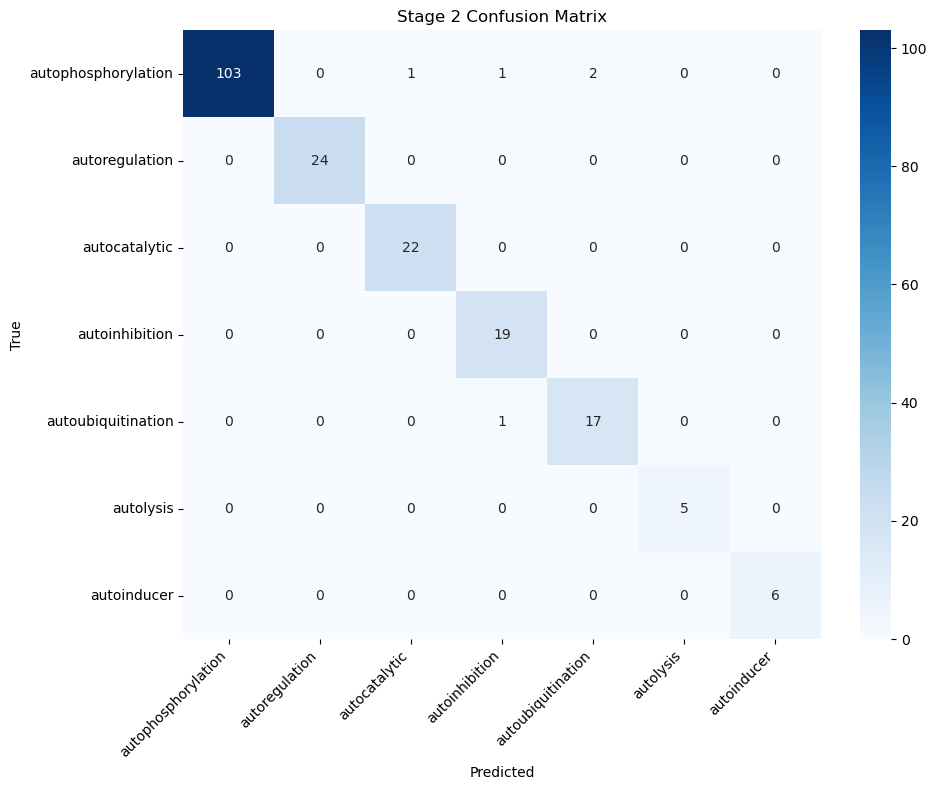


Total errors: 5 out of 201 (2.5%)


In [9]:
# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Stage 2 Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Show specific errors
errors = np.where(np.array(all_preds) != np.array(all_labels))[0]
print(f"\nTotal errors: {len(errors)} out of 201 ({len(errors)/201*100:.1f}%)")